# Assignment: Calculate wet bulb temperature for CMIP6 models

Global temperatures are increasing due to the effects of anthropogenic greenhouse gas emissions. This has many potentially disastrous consequences for many people around the world. One of the concerns is that in hot and humid climates, depending on the humidity and increase in temperature could lead to fatal conditions. 
One way to quantify the combined effect of temperature and humidity for human health is the wet bulb temperature (WBT), which can be approximated as:

![Screen Shot 2023-01-04 at 9.00.44 PM.png](https://user-images.githubusercontent.com/14314623/210852697-83d3e1f6-d7fa-416b-a6d0-b830a9a76f08.png)

[source](https://journals.ametsoc.org/view/journals/apme/50/11/jamc-d-11-0143.1.xml)

["The wet-bulb temperature is the lowest temperature that can be reached under current ambient conditions by the evaporation of water only"](https://en.wikipedia.org/wiki/Wet-bulb_temperature#:~:text=Wet%2Dbulb%20temperature%20and%20health,-See%20also%3A%20Effects&text=A%20sustained%20wet%2Dbulb%20temperature,to%20gaining%20heat%20from%20it.). Simply put, if the wet bulb temperature gets too high, the evaporation of sweat can not cool the human body sufficiently. 

A sustained wet bulb temperature >35C is likely to be fatal, but lower WBT can also be dangerous depending on other external factors (e.g. solar radiation and insufficient air flow). From [Raymond et al. 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7209987/): "for example, regions affected by the deadly 2003 European and 2010 Russian heat waves experienced TW values no greater than 28°C"

This exercise aims to practice working with the CMIP6 cloud archive by computing the wet bulb temperature from available variables and summarizing the results in timeseries plots.

> Lets start by importing matplotlib, xarray, numpy, and combined_preprocessing from xmip.preprocessing. Set the default figure size to (12, 6).  

> Then load the intake-esm collection for CMIP6 data on Google Cloud Storage (you can use xmip, as we did in the lecture, or set this up according to the [pangeo instructions](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/intake_ESM_example.html)). The result should be the same.

In [1]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


> The ingredients we need for wet bulb temperature are surface temperature and relative humidity. 

> Find the relevant variables using the [spreadheet](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271) from the lecture. You can enter multiple variables in the search query like so: `.search(..., variable_id=['a', 'b'], ...)`.

> Select a subset of the variables, the `'historical'` experiment, the native model grid, monthly output, thres models (`['NorESM2-MM', 'MPI-ESM1-2-LR', 'CanESM5']` are recommended but feel free to explore), and a single member (`'r1i1p1f1'`) for starters. *Check out some more models/members later if you are curious!*

> Then load the data into a dictionary of xarray datasets like we did in the lecture.

In [3]:
cat = col.search(variable_id = ['ts', 'hur'], experiment_id = 'historical',
                 source_id = ['NorESM2-MM', 'MPI-ESM1-2-LR', 'CanESM5'], member_id = 'r1i1p1f1',
                table_id = ["Amon"])
cat

,unique
activity_id,1
institution_id,3
source_id,3
experiment_id,1
member_id,1
table_id,1
variable_id,2
grid_label,1
zstore,6
dcpp_init_year,0


In [4]:
ddict = cat.to_dataset_dict(preprocess=combined_preprocessing,
                           xarray_open_kwargs = {"use_cftime": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
list(ddict)

['CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn',
 'CMIP.NCC.NorESM2-MM.historical.Amon.gn']

In [6]:
def wbt_cal(t, h):
    tw = t * np.atan(0.151977*(h + 8.313659) ** (0.5)) + np.atan(t + h) - \
    np.atan(h - 1.676331) + \
    0.00391838 * h ** (3/2) * np.atan(0.023101 * h) - 4.686035 
    return tw
    

wbt_cal(20, 50)

np.float64(13.699341968988136)

In [7]:
ds1 = ddict["CMIP.CCCma.CanESM5.historical.Amon.gn"].sel(plev = 100000.)
ds2 = ddict["CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn"].sel(plev = 100000.)
ds3 = ddict["CMIP.NCC.NorESM2-MM.historical.Amon.gn"].sel(plev = 100000.)


In [8]:
ds3

<xarray.Dataset> Size: 882MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                     x: 288, bnds: 2, vertex: 4)
Coordinates: (12/13)
  * y               (y) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * x               (x) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    plev            float64 8B 1e+05
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    lat_bounds      (y, bnds, x) float64 885kB dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds     (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    ...              ...
    lon             (x, y) float64 442kB 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 442kB -90.0 -89.06 -88.12 ... 89.06 90.0
    lon_verticies   (vertex, x, y) float64 2MB dask.array<chunksize=(1, 288, 192), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 2MB dask.array<chunksize=(1, 288, 192), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertex
Data variables:
    hur             (member_id, dcpp_init_year, time, y, x) float32 438MB dask.array<chunksize=(1, 1, 18, 192, 288), meta=np.ndarray>
    ts              (member_id, dcpp_init_year, time, y, x) float32 438MB dask.array<chunksize=(1, 1, 403, 192, 288), meta=np.ndarray>
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Hybrid-restart from year 1200-01-01 of ...
    branch_time:                      0.0
    branch_time_in_child:             0.0
    branch_time_in_parent:            438000.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20191108
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCC.NorESM2-MM.historical.Amon.gn

> Now lets calculate the wet bulb temperature according to the formula above. Write a function that calculates wet bulb temperature from temperature and humidity. 

> 🚨 Watch the units and convert if necessary! You can always check the units by looking at the metadata of a variable (`ds['your_variable'].attrs['units]`).

> A good test to see if your function is doint the right thing is to calculate the example from the [paper](https://journals.ametsoc.org/view/journals/apme/50/11/jamc-d-11-0143.1.xml): For relative humidity of 50% and temperature of 20C, we expect ~13.7C for the wet bulb temperature.

In [9]:
ds1_wbt = wbt_cal(ds1.ts - 273.15, ds1.hur).compute()
ds2_wbt = wbt_cal(ds2.ts - 273.15, ds1.hur).compute()
ds3_wbt = wbt_cal(ds3.ts - 273.15, ds1.hur).compute()

> To get an idea of the extremes globally lets compute the 90th percentile (`xarray.DataArray.quantile()` is your friend) of wet bulb temperature at every timesteps and then compute the annual average of that and plot is as a timeseries for each model. 

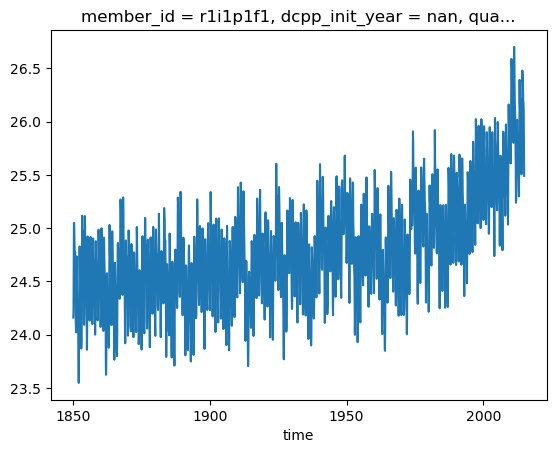

In [10]:
ds1_wbt.quantile([0.9], dim = ["x", "y"]).isel(member_id = 0, dcpp_init_year= 0).plot()

> What we are really interested in is to see how these extreme WBT are going to evolve in the future. Lets use your new CMIP6 skills to get some more data!
> Make another query to get two of the future scenario experiments (`ssp585` and `ssp245`- the 'worst case' and 'middle of the road' scenarios) for the same models and load them into separate dataset_dictionaries.

In [11]:
cat2 = col.search(variable_id = ['ts', 'hur'], experiment_id = ['ssp585', "ssp245"],
                 source_id = ['NorESM2-MM', 'MPI-ESM1-2-LR', 'CanESM5'], member_id = 'r1i1p1f1',
                table_id = ["Amon"])
cat2

ddict2 = cat2.to_dataset_dict(preprocess=combined_preprocessing,
                           xarray_open_kwargs = {"use_cftime": True})





--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [12]:
ddict2.keys()

ds1_ssp585 = ddict2["ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn"].sel(plev = 100000.)
ds2_ssp585 = ddict2["ScenarioMIP.NCC.NorESM2-MM.ssp585.Amon.gn"].sel(plev = 100000.)
ds3_ssp585 = ddict2["ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Amon.gn"].sel(plev = 100000.)

ds1_ssp245 = ddict2["ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn"].sel(plev = 100000.)
ds2_ssp245 = ddict2["ScenarioMIP.NCC.NorESM2-MM.ssp245.Amon.gn"].sel(plev = 100000.)
ds3_ssp245 = ddict2["ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn"].sel(plev = 100000.)



In [13]:
ds1_ssp585_wbt = wbt_cal(ds1_ssp585.ts - 273.15, ds1_ssp585.hur).compute()
ds2_ssp585_wbt = wbt_cal(ds2_ssp585.ts - 273.15, ds2_ssp585.hur).compute()
ds3_ssp585_wbt = wbt_cal(ds3_ssp585.ts - 273.15, ds3_ssp585.hur).compute()

ds1_ssp245_wbt = wbt_cal(ds1_ssp245.ts - 273.15, ds1_ssp245.hur).compute()
ds2_ssp245_wbt = wbt_cal(ds2_ssp245.ts - 273.15, ds2_ssp245.hur).compute()
ds3_ssp245_wbt = wbt_cal(ds3_ssp245.ts - 273.15, ds3_ssp245.hur).compute()

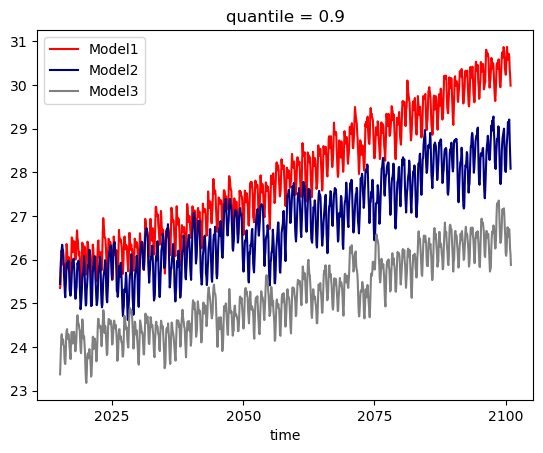

In [15]:
ds1_ssp585_wbt.isel(member_id = 0, dcpp_init_year =0).sel(time = slice("2015", "2100")).quantile(0.9,  dim = ["x", "y"]).plot(color = "red", label = "Model1")
ds2_ssp585_wbt.isel(member_id = 0, dcpp_init_year =0).quantile(0.9,  dim = ["x", "y"]).plot(color = "navy", label = "Model2")
ds3_ssp585_wbt.isel(member_id = 0, dcpp_init_year =0).quantile(0.9,  dim = ["x", "y"]).plot(color = "gray", label = "Model3")
plt.legend()

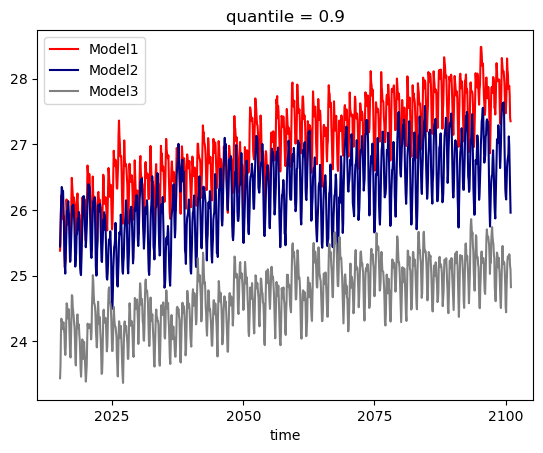

In [16]:
ds1_ssp245_wbt.isel(member_id = 0, dcpp_init_year =0).quantile(0.9,  dim = ["x", "y"]).plot(color = "red", label = "Model1")
ds2_ssp245_wbt.isel(member_id = 0, dcpp_init_year =0).quantile(0.9,  dim = ["x", "y"]).plot(color = "navy", label = "Model2")
ds3_ssp245_wbt.isel(member_id = 0, dcpp_init_year =0).quantile(0.9,  dim = ["x", "y"]).plot(color = "gray", label = "Model3")
plt.legend()

> Plot the same quantity as before (90th percentile in space and annual maximum) for each model and all 3 experiments to see how each model predicts wet bulb temperature extremes until the end of the century. Use color/linestyle/lineweight to separate the experiments.

> As a final step, lets look where these extremes occur. Plot a map of an annual average from 2099-2100 for each model and scenario. Make sure to restrict the colormap to + 30 to see where extremes occur

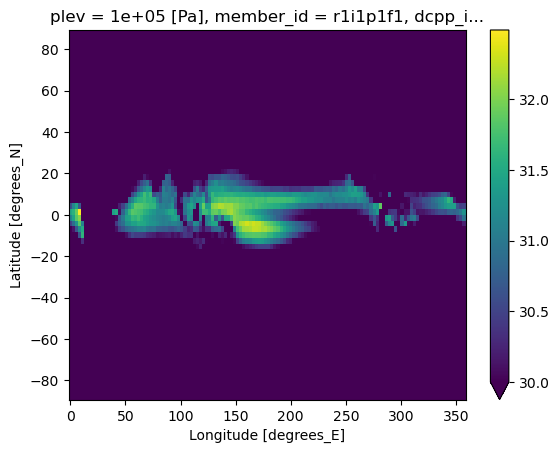

In [17]:
ds1_ssp585_wbt.isel(member_id = 0, dcpp_init_year =0).sel(time = slice("2099", "2100")).mean(dim = "time").plot(vmin = 30)